# 1_价值选股

低PE/PB/PS/PCF

本杰明·格雷厄姆的选股标准：较低的PE和PB ratio

抗风险的公司： 高市值，高销售

偿债能力： 现金流高，负债低

赚钱能力： 利润增长

## 选股步骤
1. 导入模块并选定股票池范围
2. 获取因子的Panel与价格的DataFrame
3. 对数据进行标准化处理
4. 输入因子算法，输出因子的Pipeline格式
5. 用Alphalens输出Quantile为5的股票列表
6. 显示Quantile收益与因子IC值并保存成Excel

## Step1 导入需要的模块

In [1]:
from jaqs.data import DataView
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


## Step2 获取因子的Panel与价格的DataFrame

In [2]:
def change_columns_index(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    signal.index = pd.Index(map(lambda x: x+timedelta(hours=15) , signal.index))
    return signal


all_factor = ['pb', 'ps_ttm', 'pe_ttm']

origin_factors = {f: change_columns_index(dv.get_ts(f, start_date=20140104)) for f in all_factor}

## Step3 对数据进行标准化处理

In [3]:
from jaqs.research.signaldigger import process
#去极值,z_score标准化,加干扰值
PN_disturbed = pd.Panel({name: process.get_disturbed_factor(process.standardize(process.winsorize(frame)))
                         for name, frame in origin_factors.items()})

In [4]:
prices = change_columns_index(dv.get_ts('close_adj'))

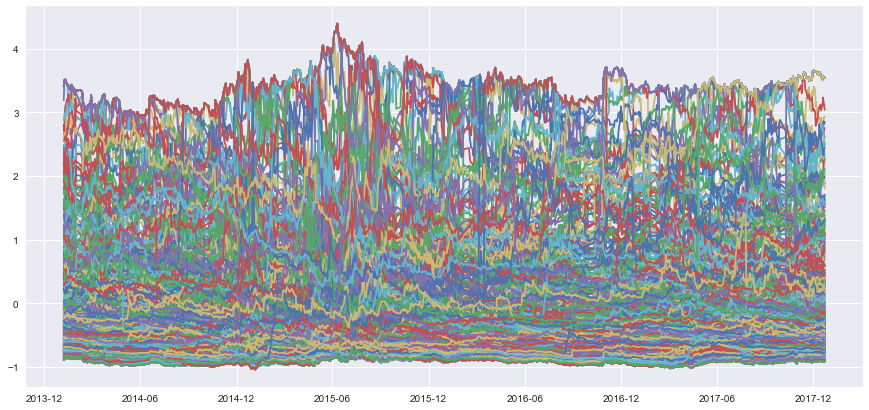

In [5]:
fig = plt.figure(figsize=(15, 7))
plt.plot(PN_disturbed['pb'])
plt.show()

## Step4 输入因子算法，输出因子的Pipeline格式

In [6]:
S = -(PN_disturbed['pb']+2*PN_disturbed['pe_ttm']+PN_disturbed['ps_ttm'])
factor = S.stack()

print(factor)

                     symbol     
2014-01-06 15:00:00  000001.XSHE     2.614823
                     000002.XSHE     2.817325
                     000008.XSHE    -1.357455
                     000009.XSHE     0.410360
                     000012.XSHE     0.817708
                     000021.XSHE     0.603947
                     000024.XSHE     2.681355
                     000027.XSHE     2.572229
                     000031.XSHE     2.520730
                     000039.XSHE     1.215881
                     000046.XSHE     1.012852
                     000059.XSHE    -2.155490
                     000060.XSHE     0.375343
                     000061.XSHE     1.441537
                     000063.XSHE     2.792689
                     000069.XSHE     2.500499
                     000100.XSHE     2.471629
                     000156.XSHE    -8.654189
                     000157.XSHE     2.655292
                     000333.XSHE     1.784511
                     000338.XSHE     2.534469
 

## Step5 用Alphalens输出Quantile为5的股票列表

In [7]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
factor_data

Dropped 1.1% entries from factor data (1.1% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


1         5        10     factor  \
date                asset                                                  
2014-01-06 15:00:00 000001.XSHE -0.003428 -0.005998 -0.031705   2.614823   
                    000002.XSHE -0.006684 -0.032086 -0.046791   2.817325   
                    000008.XSHE -0.014101 -0.007051 -0.005875  -1.357455   
                    000009.XSHE -0.002205 -0.034179 -0.054024   0.410360   
                    000012.XSHE -0.005284 -0.055482  0.002642   0.817708   
                    000021.XSHE  0.046642  0.097015  0.113806   0.603947   
                    000024.XSHE -0.021978 -0.094192 -0.099948   2.681355   
                    000027.XSHE -0.003831 -0.009579 -0.015326   2.572229   
                    000031.XSHE  0.002833 -0.062323 -0.062323   2.520730   
                    000039.XSHE  0.030263  0.009868  0.074342   1.215881   
                    000046.XSHE -0.016204 -0.006944 -0.004630   1.012852   
                    000059.XSHE -0.017505 -0.024070 -0.061269  -2.155490   
                    000060.XSHE  0.000000 -0.116242 -0.116242   0.375343   
                    000061.XSHE  0.008816 -0.005038 -0.010076   1.441537   
                    000063.XSHE -0.019076 -0.085840 -0.101247   2.792689   
                    000069.XSHE -0.004016 -0.052209 -0.076305   2.500499   
                    000100.XSHE  0.000000  0.004405  0.004405   2.471629   
                    000156.XSHE -0.005301  0.032289  0.021687  -8.654189   
                    000157.XSHE  0.003876 -0.021318 -0.031008   2.655292   
                    000333.XSHE -0.003218 -0.002360  0.019309   1.784511   
                    000338.XSHE  0.002259 -0.028797 -0.011858   2.534469   
                    000400.XSHE  0.083607  0.064262  0.106557  -0.200719   
                    000401.XSHE -0.005128 -0.093590 -0.065385  -1.576662   
                    000402.XSHE -0.006024 -0.028112 -0.040161   2.935479   
                    000413.XSHE  0.022311  0.013158  0.131007  -4.715769   
                    000415.XSHE  0.030667 -0.026667  0.124000   1.549563   
                    000422.XSHE -0.001692 -0.038917 -0.042301   2.751580   
                    000423.XSHE -0.018435 -0.063528 -0.094918  -0.848219   
                    000425.XSHE  0.006916 -0.048409 -0.058091   2.801978   
                    000503.XSHE -0.012981 -0.006490  0.009985 -14.537425   
...                                   ...       ...       ...        ...   
2017-12-08 15:00:00 601881.XSHG  0.010714 -0.013393 -0.042857   0.130099   
                    601888.XSHG  0.039409 -0.010791  0.022754  -1.062103   
                    601898.XSHG -0.001709 -0.037607 -0.032479   2.491740   
                    601899.XSHG  0.002591  0.031088  0.077720   1.087548   
                    601901.XSHG  0.007032 -0.014065 -0.025316  -1.244926   
                    601918.XSHG  0.005236  0.007853  0.010471  -0.274719   
                    601919.XSHG  0.033083 -0.012030  0.003008   0.936680   
                    601928.XSHG  0.016787 -0.003597 -0.009592   2.137602   
                    601929.XSHG  0.010169  0.003390 -0.003390   1.235568   
                    601933.XSHG  0.000000  0.000000  0.083845  -0.973363   
                    601939.XSHG  0.001431 -0.002861  0.034335   2.791316   
                    601958.XSHG  0.004280 -0.014265 -0.011412  -6.807159   
                    601966.XSHG  0.010366  0.012195  0.048171   1.842754   
                    601969.XSHG  0.013746 -0.002291 -0.002291   0.917216   
                    601985.XSHG -0.002667 -0.029333 -0.032000   1.008375   
                    601988.XSHG  0.002551 -0.015306 -0.005102   3.009750   
                    601989.XSHG  0.003236 -0.032362 -0.048544  -4.454526   
                    601991.XSHG  0.014252 -0.016627 -0.004751   2.252139   
                    601992.XSHG  0.010221 -0.035775 -0.071550   2.345856   
                    601997.XSHG  0.009818 -0.039972 -0.049790   2.656206   
            

## Step6 显示Quantile收益与因子IC值

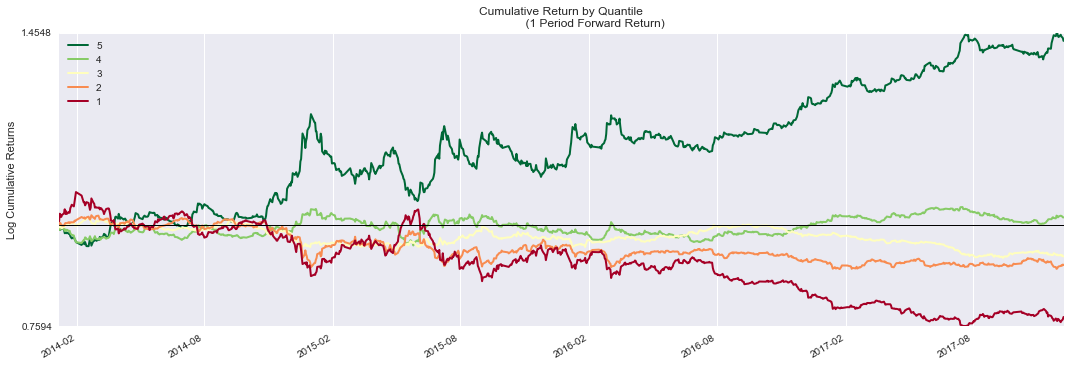

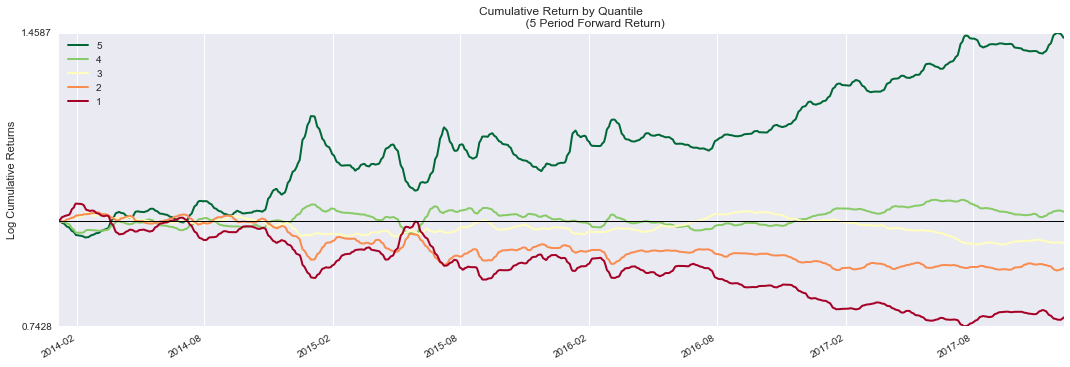

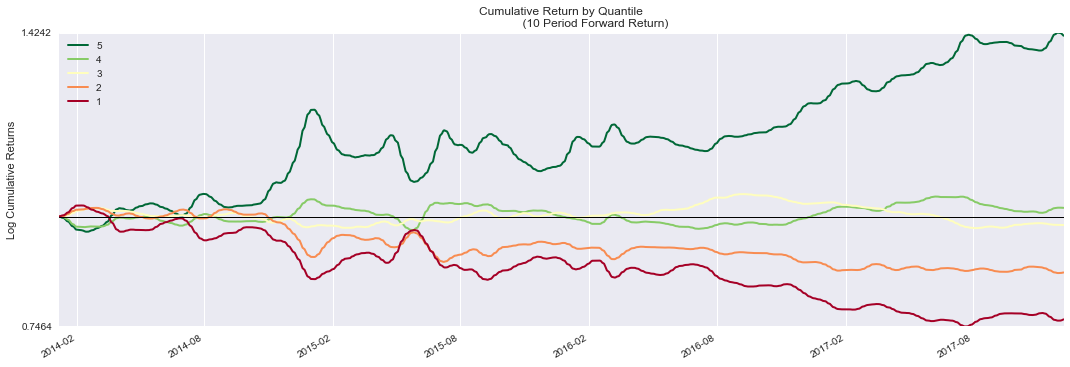

In [8]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

                  1         5         10
date                                    
2014-01-31 -0.070001 -0.126217 -0.136261
2014-02-28  0.044049  0.082265  0.124464
2014-03-31  0.075613  0.197741  0.246418
2014-04-30 -0.021004 -0.037856  0.011392
2014-05-31  0.004066 -0.022757 -0.075638
2014-06-30 -0.011978 -0.057123 -0.047056
2014-07-31  0.104077  0.214181  0.225572
2014-08-31 -0.034879 -0.103149 -0.106186
2014-09-30  0.053786  0.059193  0.078409
2014-10-31  0.053084  0.112624  0.207424
2014-11-30  0.055736  0.117497  0.188480
2014-12-31  0.129429  0.234187  0.269155
2015-01-31 -0.074664 -0.192011 -0.241059
2015-02-28 -0.015963 -0.088749 -0.098796
2015-03-31  0.005694  0.040795  0.053818
2015-04-30  0.047669  0.047294 -0.018095
2015-05-31 -0.073871 -0.126950 -0.078630
2015-06-30  0.098156  0.213868  0.250445
2015-07-31  0.021326  0.028621  0.005530
2015-08-31  0.011804  0.055591  0.099698
2015-09-30 -0.043432 -0.109663 -0.174459
2015-10-31 -0.013048 -0.047885 -0.066241
2015-11-30  0.00

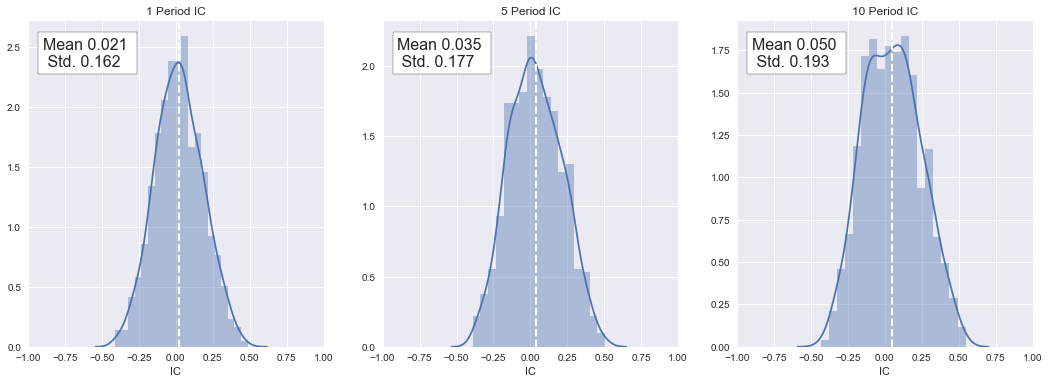

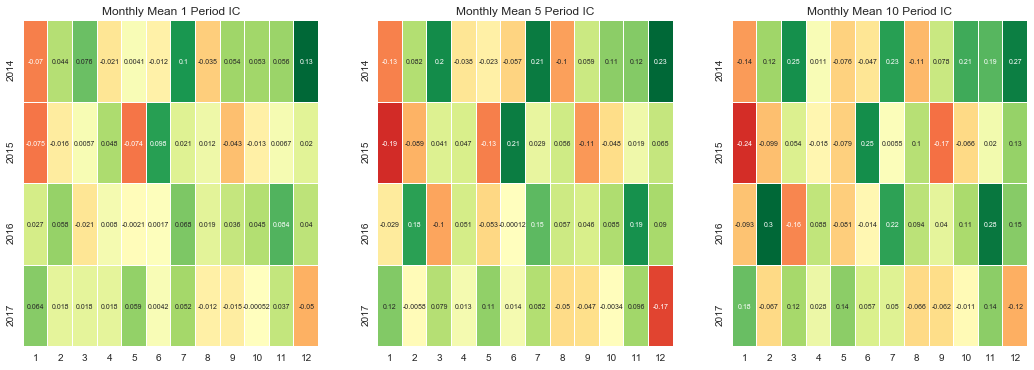

In [9]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
# print ic
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
print (mean_monthly_ic)
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()

In [10]:
excel_data = factor_data[factor_data.factor_quantile==5].factor_quantile.unstack().replace(np.nan, 0).replace(5, 1)
excel_data.to_excel('factor.xlsx')

In [11]:
excel_data

asset,000001.XSHE,000002.XSHE,000012.XSHE,000024.XSHE,000027.XSHE,000031.XSHE,000039.XSHE,000059.XSHE,000063.XSHE,000069.XSHE,...,601939.XSHG,601958.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601991.XSHG,601992.XSHG,601997.XSHG,601998.XSHG,603885.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2014-01-06 15:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-07 15:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-08 15:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-09 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-10 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-13 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-14 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-15 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2014-01-16 15:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
